In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../data/processed/processed.csv', index_col=0)

df.head()

,price,category,beds,livings,wc,area,street_width,age,street_direction,ketchen,...,rent_period_2.0,rent_period_3.0,advertiser_type_agent,advertiser_type_exclusive_marketer,advertiser_type_normal_marketer,advertiser_type_owner,daily_rentable_0.0,daily_rentable_1.0,user.iam_verified_0.0,user.iam_verified_1.0
2308,5500.0,1,1.0,1.0,1.0,160.0,18.0,2.0,3.0,1.0,...,True,False,False,True,False,False,True,False,False,True
2366,2000.0,1,3.0,1.0,1.0,160.0,18.0,0.0,3.0,1.0,...,True,False,True,False,False,False,True,False,False,True
2405,50000.0,5,7.0,2.0,5.0,900.0,30.0,30.0,8.0,0.0,...,False,True,False,True,False,False,True,False,False,True
2434,1500.0,1,1.0,1.0,1.0,50.0,5.0,2.0,3.0,1.0,...,True,False,False,False,False,True,True,False,False,True
2435,1500.0,1,1.0,1.0,1.0,160.0,18.0,2.0,3.0,1.0,...,True,False,False,False,False,True,True,False,False,True


In [6]:
# important = ['advertiser_type_normal_marketer',
#  'advertiser_type_agent',
#  'all_inclusive',
#  'rent_period_1.0',
#  'is_store',
#  'furnished',
#  'beds',
#  'rent_period_2.0',
#  'user.review',
#  'street_width',
#  'street_direction',
#  'is_land',
#  'create_time',
#  'ac',
#  'rent_period_3.0',
#  'city_id',
#  'age',
#  'is_villa',
#  'number_of_rooms',
#  'livings',
#  'wc',
#  'is_appartement',
#  'category',
#  'location.lng',
#  'area',
#  'district_id',
#  'location.lat',
#  'is_sell',
#  'is_rent']

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_sell = X[X.is_sell]
y_sell = y[X.is_sell]

X_rent = X[X.is_rent]
y_rent = y[X.is_rent]

X_sell_train, X_sell_test, y_sell_train, y_sell_test = train_test_split(X_sell, y_sell, test_size=0.2, random_state=42)
X_rent_train, X_rent_test, y_rent_train, y_rent_test = train_test_split(X_rent, y_rent, test_size=0.2, random_state=42)

In [233]:
import catboost as cb

model = cb.CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

model

In [234]:
len(X.columns)

47

In [235]:
res = model.select_features(X, y=y, eval_set=(X_test, y_test), features_for_select=X.columns, num_features_to_select=26, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [236]:
selected = res['selected_features_names']
selected

['category',
 'beds',
 'livings',
 'wc',
 'area',
 'street_width',
 'age',
 'street_direction',
 'ac',
 'furnished',
 'location.lat',
 'location.lng',
 'user.review',
 'city_id',
 'district_id',
 'create_time',
 'number_of_rooms',
 'is_appartement',
 'is_land',
 'is_villa',
 'is_building',
 'is_sell',
 'is_rent',
 'rent_period_1.0',
 'rent_period_2.0',
 'rent_period_3.0']

In [226]:
# grid = {'iterations': [200, 300, 500],
#         'learning_rate': [3e-4, 0.01, 0.03, 0.1],
#         'depth': [2, 4, 6, 8],
#         'l2_leaf_reg': [0.2, 0.5, 1, 3]}

# model = cb.CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

# # model.fit(X_train[selected], y_train)
# grid_search_result = model.grid_search(
#     grid,
#     X=X_train[selected],
#     y=y_train,
#     plot=True
# )

In [227]:
# grid_search_result['params']

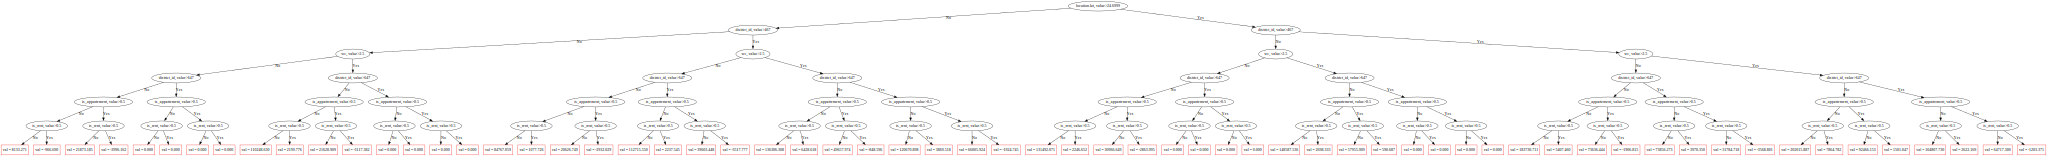

In [244]:
model.plot_tree(tree_idx=0, pool=X_test)

In [237]:
prediction = model.predict(X_test[selected])

In [238]:
prediction

array([70291.59261695, 29153.43185127, 17866.25402873, ...,
       35694.5216227 , 31435.36604569, 24123.39583773])

In [239]:
print('Y test')
print(y_test.describe())
print()
print('Y pred')
print(pd.Series(prediction).describe())
print()


Y test
count    1.821400e+04
mean     5.271214e+04
std      1.232284e+05
min      1.700000e+01
25%      2.000000e+04
50%      3.200000e+04
75%      5.700000e+04
max      2.567400e+06
Name: price, dtype: float64

Y pred
count    1.821400e+04
mean     5.283666e+04
std      1.201121e+05
min     -1.762079e+04
25%      2.063196e+04
50%      3.411136e+04
75%      5.924214e+04
max      2.476567e+06
dtype: float64



In [240]:
from sklearn import metrics

def print_metrics(preds, gts):
    print(f"MAE: {metrics.mean_absolute_error(gts, preds)}")
    print(f"MSE: {metrics.mean_squared_error(gts, preds)}")
    print(f"RMSE: {metrics.root_mean_squared_error(gts, preds)}")
    print(f"R2: {metrics.r2_score(gts, preds)}")
    print(f"MAPE: {metrics.mean_absolute_percentage_error(gts, preds)}")


print_metrics(prediction, y_test)

MAE: 10073.93637969401
MSE: 506385065.50764114
RMSE: 22503.001255557916
R2: 0.9666509822592115
MAPE: 2.368018311346091


default + All
MAE: 12685.260942046447
MSE: 1884201637.0192149
RMSE: 43407.39150213031
R2: 0.8759120714644607
MAPE: 2.479405372105791

default + Important 0.1 (from all)
MAE: 12660.003927921938
MSE: 1857534224.7071507
RMSE: 43099.120927313015
R2: 0.8776683081050584
MAPE: 2.4674582345198726

default + Important 0.2 (from 0.1)
MAE: 12598.315785151302
MSE: 1816768356.4734898
RMSE: 42623.56574095473
R2: 0.8803530272161564
MAPE: 2.467720767547896


mae + {'depth': 8, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}
MAE: 12187.250663391844
MSE: 2337699684.329189
RMSE: 48349.7640566031
R2: 0.846046035802465
MAPE: 2.355927033709212


rmse with uncertanty + {'depth': 6, 'l2_leaf_reg': 3, 'iterations': 200, 'learning_rate': 0.1}
MAE: 13611.386657664354
MSE: 1946929097.5812862
RMSE: 44124.01950844105
R2: 0.871781027052592
MAPE: 2.765250145617463

rmse + {'depth': 6, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}
MAE: 12781.091155105873
MSE: 1959357291.3993628
RMSE: 44264.62799345955
R2: 0.8709625430878062
MAPE: 2.5610253097465705

rent only + {'depth': 6, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 0.2}
MAE: 10714.122395386801
MSE: 739843920.1140379
RMSE: 27200.072060824357
R2: 0.6617022067964718
MAPE: 2.623073551022946

sell only + {'depth': 4, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}
MAE: 262692.69712599774
MSE: 132045417635.70651
RMSE: 363380.5410801554
R2: 0.6491855548003518
MAPE: 0.2932232645064311

select 30
MAE: 10393.651831574554
MSE: 551612322.3686267
RMSE: 23486.428471962838
R2: 0.963672449332076
MAPE: 2.39605070919952

select 35
MAE: 10368.797760826727
MSE: 555312979.1254269
RMSE: 23565.07965455298
R2: 0.9634287350595956
MAPE: 2.388146405311896

In [168]:
model.get_feature_importance()[model.get_feature_importance() != 0]

array([ 1.69589455,  0.15408224,  0.61033098,  1.69501638,  4.51016247,
        0.55632021,  0.75900613,  0.5258138 ,  0.51722813,  0.2730924 ,
        5.68924926,  4.01121077,  0.40181947,  0.47923263,  5.1253933 ,
        0.53507002,  1.28069979,  6.41352334,  0.63489231,  0.27537062,
        0.16199627, 12.95756138, 49.66320464,  0.10905167,  0.39827668,
        0.56650057])

Text(0.5, 1.0, 'Feature Importance')

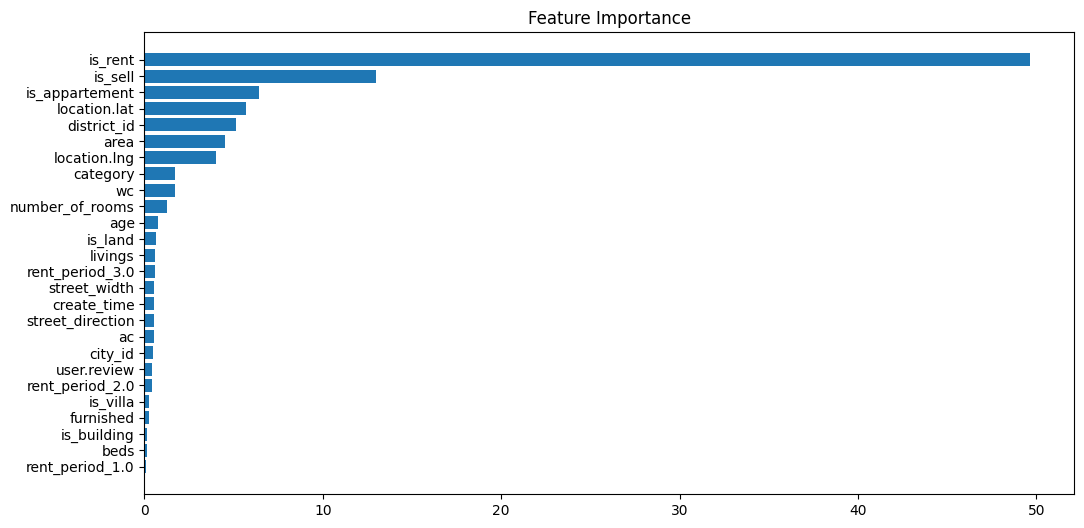

In [186]:
import numpy as np


feature_importance = model.get_feature_importance() # [model.get_feature_importance() != 0]
sorted_idx = np.argsort(feature_importance)

for split in range(len(sorted_idx)-1, -1, -1):
    if feature_importance[sorted_idx[split]] == 0:
        sorted_idx = sorted_idx[split+1:]
        break

ignore_k = -100

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx))[:-ignore_k], feature_importance[sorted_idx][:-ignore_k], align='center')

plt.yticks(range(len(sorted_idx))[:-ignore_k], np.array(X_test.columns)[sorted_idx][:-ignore_k])
plt.title('Feature Importance')

In [73]:
print('Best found columns is base model (no split)')
important

Best found columns is base model (no split)


['advertiser_type_normal_marketer',
 'advertiser_type_agent',
 'all_inclusive',
 'rent_period_1.0',
 'is_store',
 'furnished',
 'beds',
 'rent_period_2.0',
 'user.review',
 'street_width',
 'street_direction',
 'is_land',
 'create_time',
 'ac',
 'rent_period_3.0',
 'city_id',
 'age',
 'is_villa',
 'number_of_rooms',
 'livings',
 'wc',
 'is_appartement',
 'category',
 'location.lng',
 'area',
 'district_id',
 'location.lat',
 'is_sell',
 'is_rent']

In [30]:
dir(model)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_calc_leaf_indexes',
 '_base_drop_unused_features',
 '_base_eval_metrics',
 '_base_predict',
 '_base_shrink',
 '_base_virtual_ensembles_predict',
 '_calc_fstr',
 '_calc_leaf_indexes',
 '_calc_ostr',
 '_check_is_compatible_loss',
 '_convert_to_asymmetric_representation',
 '_dataset_train_eval_split',
 '_deserialize_model',
 '_estimator_type',
 '_eval_metrics',
 '_fit',
 '_get_borders',
 '_get_cat_feature_indices',
 '_get_default_prediction_type',
 '_get_embedding_feature_indices',
 '_get_float_feature_indices',
 '_get_nan_treatments',
 '_get_params',
 '_

In [242]:
model.get_embedding_feature_indices()

[]